In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torchsummary import summary

from sklearn.model_selection import train_test_split

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
%matplotlib inline

#Download dataset zip

In [ ]:
!gdown 1RbxAgZOqQ_NUPHCeo8ryP_ibRQpnm6Li

Downloading...
From (original): https://drive.google.com/uc?id=1RbxAgZOqQ_NUPHCeo8ryP_ibRQpnm6Li
From (redirected): https://drive.google.com/uc?id=1RbxAgZOqQ_NUPHCeo8ryP_ibRQpnm6Li&confirm=t&uuid=667e0b29-5863-4bf2-907a-1c635000d80a
To: /content/flower_dataset.zip
100% 88.3M/88.3M [00:01<00:00, 87.6MB/s]


#unzip file

In [ ]:
!unzip flower_dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: flower_dataset/rose_93_core2.png  
 extracting: flower_dataset/azalea_344_core6_flip.png  
 extracting: flower_dataset/azalea_351_core6_flip.png  
 extracting: flower_dataset/rose_226_core2.png  
 extracting: flower_dataset/sunflower_358_core5.png  
 extracting: flower_dataset/orchid_243_core6.png  
 extracting: flower_dataset/sunflower_5_core3_flip.png  
  inflating: flower_dataset/orchid_353_core4.png  
  inflating: flower_dataset/marigold_327_core2_flip.png  
 extracting: flower_dataset/sunflower_168_core6_flip.png  
  inflating: flower_dataset/rose_294_core4_flip.png  
 extracting: flower_dataset/rose_281_core4_flip.png  
  inflating: flower_dataset/marigold_332_core2_flip.png  
 extracting: flower_dataset/orchid_62_core6.png  
 extracting: flower_dataset/azalea_47_core5.png  
 extracting: flower_dataset/azalea_76_core1_flip.png  
 extracting: flower_dataset/azalea_113_core4.png  
 extracting: flower_dataset/rose_181_c

#Convert Images to Datas

#

torch.Size([3, 32, 32])


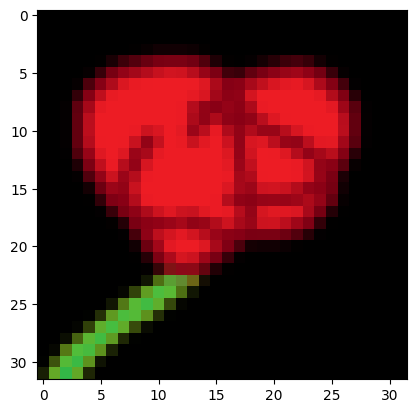

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from typing import Optional, Callable

class FlowerImageDataset(Dataset):
    def __init__(self, flower_dir: str, transform):
        self.flower_dir = flower_dir
        self.transform = transform

        self.list = sorted([
            f for f in os.listdir(self.flower_dir)
            if os.path.isfile(os.path.join(self.flower_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

        slice_list = int(len(self.list)*0.2)
        self.list = self.list[:slice_list]

        if len(self.list) == 0:
            raise ValueError(f"No data found in {self.flower_dir}")

    def __len__(self):
        return len(self.list)

    def __getitem__(self, idx):
        flower_path = os.path.join(self.flower_dir, self.list[idx])
        flower_img = Image.open(flower_path).convert("RGB")

        if self.transform:
            flower_img = self.transform(flower_img)

        return flower_img


from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = FlowerImageDataset("/content/flower_dataset", transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

for img in dataloader:
    print(img[0].shape)
    img_sample = img[0].permute(1,2,0)
    plt.imshow(img_sample)
    break



#UnetBlock

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
    super().__init__()
    if down:
      self.block =nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 4,2,1),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.2, inplace=True)
      )
    else:
      self.block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )

    self.use_dropout = use_dropout
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
      x = self.block(x)
      return self.dropout(x) if self.use_dropout else x


#Generator

In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()

        # --- Encoder ---
        self.down1 = UNetBlock(in_channels, 32)     # 32x32 -> 16x16
        self.down2 = UNetBlock(32, 64)              # 16x16 -> 8x8
        self.down3 = UNetBlock(64, 128)             # 8x8 -> 4x4

        # --- Bottleneck ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(inplace=True)
        )

        # --- Decoder ---
        self.up1 = UNetBlock(256, 128, down=False, use_dropout=True)  # 4x4 -> 8x8
        self.up2 = UNetBlock(256, 64, down=False)                     # (128+128)=256 -> 16x16
        self.up3 = UNetBlock(128, 32, down=False)                     # (64+64)=128 -> 32x32

        # --- Output ---
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        bottleneck = self.bottleneck(d3)

        # Decoder with skip connections
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))

        out = self.final(torch.cat([u3, d1], dim=1))
        return out

#Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=4):
        """
        in_channels = 1 (grayscale) + 3 (RGB) = 4 total channels
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 1),  # Patch output
            nn.Sigmoid()
        )

    def forward(self, gray_img, color_img):
        # Concatenate grayscale + generated (or real) RGB image
        x = torch.cat([gray_img, color_img], dim=1)
        return self.model(x)


#Transform Image

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])


dataset = FlowerImageDataset("/content/flower_dataset", transform=transform)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42,shuffle=True)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

#Config Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = UNetGenerator().to(device)
disc = PatchDiscriminator().to(device)

criterion = nn.BCELoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=1e-5, betas=(0.5, 0.999))


#Train Model

In [ ]:
epochs = 10


for epoch in range(epochs):
    for real_color in train_loader:
        # Convert color image to grayscale (input for generator)
        real_gray = real_color.mean(dim=1, keepdim=True).to(device)
        real_color = real_color.to(device)
        batch_size = real_color.size(0)

        ### Train Discriminator ###
        fake_color = gen(real_gray)

        # Real pair
        disc_real = disc(real_gray, real_color).view(-1)
        loss_real = criterion(disc_real, torch.ones_like(disc_real))

        # Fake pair
        disc_fake = disc(real_gray, fake_color.detach()).view(-1)
        loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_real + loss_fake) / 2
        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator ###
        output = disc(real_gray, fake_color).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))  # want to fool D

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_disc:.4f} | G Loss: {loss_gen:.4f}")


#Test Model

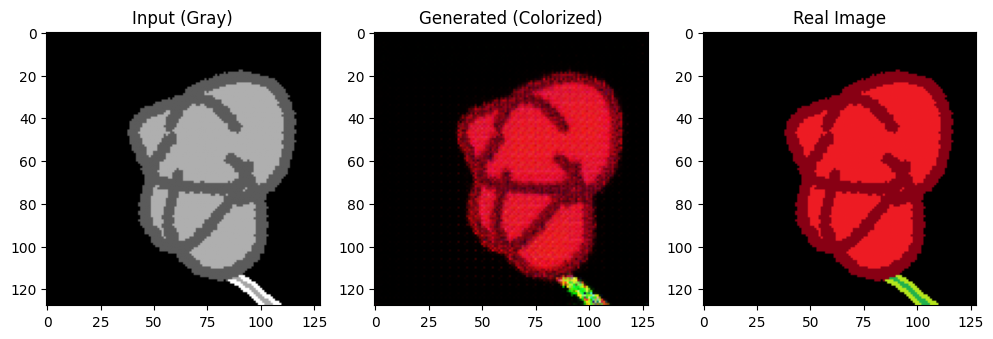

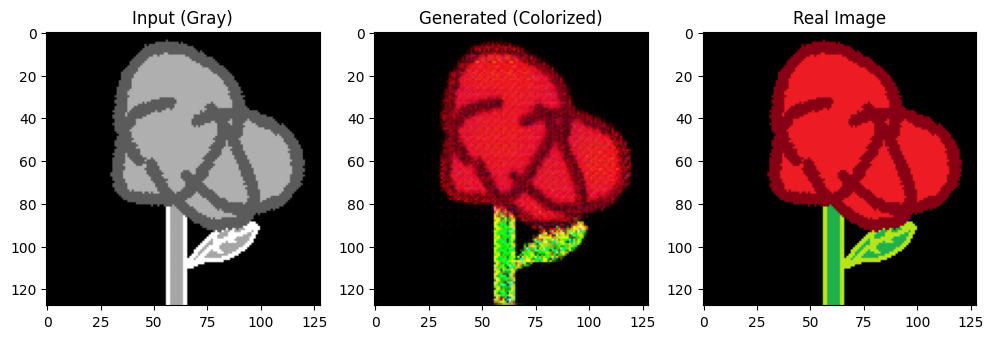

In [ ]:
import matplotlib.pyplot as plt

gen.eval()
real_img = []
with torch.no_grad():
    for real_color in test_loader:
        real_img.append(real_color)
        real_gray = real_color.mean(dim=1, keepdim=True).to(device)
        fake_color = gen(real_gray).cpu() * 0.5 + 0.5  # rescale to [0,1]
        real_color = real_color.cpu() * 0.5 + 0.5      # rescale real too
        break

# Show first sample
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_gray[0].squeeze(0).cpu(), cmap='gray')
plt.title("Input (Gray)")

plt.subplot(1, 3, 2)
plt.imshow(fake_color[0].permute(1, 2, 0))
plt.title("Generated (Colorized)")

plt.subplot(1, 3, 3)
plt.imshow(real_color[0].permute(1, 2, 0))
plt.title("Real Image")
plt.show()

# Show second sample
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_gray[1].squeeze(0).cpu(), cmap='gray')
plt.title("Input (Gray)")

plt.subplot(1, 3, 2)
plt.imshow(fake_color[1].permute(1, 2, 0))
plt.title("Generated (Colorized)")

plt.subplot(1, 3, 3)
plt.imshow(real_color[1].permute(1, 2, 0))
plt.title("Real Image")
plt.show()
